In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_map = {
    "2016": "d16_v4.csv",
    "2017": "d17_v4.csv",
    "2018": "d18_v4.csv",
    "2019": "d19_v4.csv",
    "2020": "d20_v4.csv",
    "2021": "d21_v4.csv",
    "2022": "d22_v4.csv",
    "2023": "d23_v4.csv"
}

top_substances = [
    "Indeno(1,2,3-cd)pyrene",
    "Benzo(a)pyrene",
    "Cypermethrin",
    "Fluoranthene",
    "Copper"
]

dfs = []
for year, file in file_map.items():
    df = pd.read_csv(file)
    df["YEAR"] = int(year)
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)


full_df.columns = full_df.columns.str.strip()
full_df["SUBSTANCE NAME"] = full_df["SUBSTANCE NAME"].astype(str).str.strip()
full_df["REGION"] = full_df["REGION"].astype(str).str.strip()
full_df["QUANTITY RELEASED (kg)"] = pd.to_numeric(full_df["QUANTITY RELEASED (kg)"], errors='coerce')

#PNEC
pnec_dict = {
    "indeno(1,2,3-cd)pyrene": 0.00017,
    "benzo(a)pyrene": 0.00017,
    "cypermethrin": 3e-05,
    "fluoranthene": 0.000762,
    "copper": 1.0
}


full_df["SUBSTANCE NAME"] = full_df["SUBSTANCE NAME"].astype(str).str.strip().str.lower()

def compute_toxicity_proxy(row):
    substance = row["SUBSTANCE NAME"]
    quantity_kg = row["QUANTITY RELEASED (kg)"]
    pnec = pnec_dict.get(substance)
    if pd.notna(quantity_kg) and substance in pnec_dict:
        return (quantity_kg * 1e9) / pnec  # kg to µg, then divide by PNEC
    return None

full_df["TOXIC LITRES REQUIRED"] = full_df.apply(compute_toxicity_proxy, axis=1)


In [20]:
import pandas as pd


col_toxic  = 'TOXIC LITRES REQUIRED'
col_mass   = 'QUANTITY RELEASED (kg)'
col_county = 'COUNTY'
col_year   = 'YEAR'


df = full_df[[col_toxic, col_mass, col_county, col_year]].copy()


df[col_year] = pd.to_numeric(df[col_year], errors='coerce').astype('Int64')
df[col_toxic] = pd.to_numeric(df[col_toxic], errors='coerce')
df[col_mass] = pd.to_numeric(df[col_mass], errors='coerce')


df = df.dropna(subset=[col_county, col_year])


grouped = df.groupby([col_county, col_year], dropna=False).agg({
    col_toxic: 'sum',
    col_mass: 'sum'
}).reset_index()


def make_wide(value_col):
    wide = grouped.pivot_table(index=col_county,
                               columns=col_year,
                               values=value_col,
                               aggfunc='sum')
    wide = wide.sort_index().reset_index()
    wide.columns = [str(c) if isinstance(c, str) else str(int(c)) for c in wide.columns]
    return wide

wide_toxic = make_wide(col_toxic)
wide_mass  = make_wide(col_mass)

# Save
#wide_toxic.to_csv('pollution_toxic_litres_by_county_year.csv', index=False)
#wide_mass.to_csv('pollution_mass_released_by_county_year.csv', index=False)

#print("Saved combined toxic litres and mass released tables.")


In [21]:
wide_mass['COUNTY'].unique()

array(['Barking and Dagenham', 'Barnsley', 'Bath and North East Somerset',
       'Bedford', 'Bexley', 'Birmingham', 'Blackpool', 'Bolton',
       'Bournemouth, Christchurch and Poole', 'Bradford',
       'Bristol, City of', 'Buckinghamshire', 'Bury', 'Calderdale',
       'Cambridgeshire', 'Central Bedfordshire', 'Cheshire East',
       'Cheshire West and Chester', 'Cornwall', 'County Durham',
       'Coventry', 'Cumberland', 'Darlington', 'Derby', 'Derbyshire',
       'Devon', 'Doncaster', 'Dorset', 'Dudley', 'Ealing',
       'East Riding of Yorkshire', 'East Sussex', 'Enfield', 'Essex',
       'Gateshead', 'Gloucestershire', 'Halton', 'Hammersmith and Fulham',
       'Hampshire', 'Hartlepool', 'Havering', 'Herefordshire, County of',
       'Hertfordshire', 'Hillingdon', 'Hounslow', 'Isle of Wight', 'Kent',
       'Kingston upon Hull, City of', 'Kingston upon Thames', 'Kirklees',
       'Knowsley', 'Lambeth', 'Lancashire', 'Leeds', 'Leicester',
       'Leicestershire', 'Lewisham', 'Li

In [22]:
wide_toxic = wide_toxic.rename(columns={'COUNTY': 'UTLA'})
wide_mass = wide_mass.rename(columns={'COUNTY': 'UTLA'})
wide_toxic = wide_toxic.fillna(0)
wide_mass = wide_mass.fillna(0)
wide_mass

#wide_toxic.to_csv('pollution_toxic_litres_by_county_year.csv', index=False)
#wide_mass.to_csv('pollution_mass_released_by_county_year.csv', index=False)
def remove_rhondda(wide_mass, wide_toxic):
    wide_mass = wide_mass[wide_mass['UTLA'] != 'Rhondda Cynon Taf']
    wide_toxic = wide_toxic[wide_toxic['UTLA'] != 'Rhondda Cynon Taf']
    return wide_mass, wide_toxic
wide_mass, wide_toxic = remove_rhondda(wide_mass, wide_toxic)

In [23]:

pop = pd.read_csv("utla_population_2016_2023.csv")  # UTLA + 2016..2023
unemp = pd.read_csv("unemployment_rates_2016_2023.csv")
enterprises = pd.read_csv("active_enterprises_2016_2023.csv")
pay = pd.read_csv("median_weekly_pay_2016_2023.csv")

def melt_wide(df, id_col, var_name):
    df_long = df.melt(id_vars=[id_col], var_name="Year", value_name=var_name)
    df_long["Year"] = df_long["Year"].astype(int)  # ensure numeric year
    return df_long

mass_long = melt_wide(wide_mass, "UTLA", "Pollution_mass")
toxic_long = melt_wide(wide_toxic, "UTLA", "Pollution_toxic")
pop_long = melt_wide(pop, "UTLA", "Population")
unemp_long = melt_wide(unemp, "UTLA", "Unemployment_rate")
ent_long = melt_wide(enterprises, "UTLA", "Active_enterprises")
pay_long = melt_wide(pay, "UTLA", "Median_weekly_pay")

df = (
    mass_long
    .merge(toxic_long, on=["UTLA", "Year"], how="left")
    .merge(pop_long, left_on=["UTLA","Year"], right_on=["UTLA","Year"], how="left")
    .merge(unemp_long, left_on=["UTLA","Year"], right_on=["UTLA","Year"], how="left")
    .merge(ent_long, left_on=["UTLA","Year"], right_on=["UTLA","Year"], how="left")
    .merge(pay_long, left_on=["UTLA","Year"], right_on=["UTLA","Year"], how="left")
)

df = df.drop(columns=["UTLA_x", "UTLA_y"], errors="ignore")

df["Pollution_mass"] = df["Pollution_mass"].fillna(0)
df["Pollution_toxic"] = df["Pollution_toxic"].fillna(0)

df.to_csv("panel_regression_data.csv", index=False)

df


,UTLA,Year,Pollution_mass,Pollution_toxic,Population,Unemployment_rate,Active_enterprises,Median_weekly_pay
0,Barking and Dagenham,2016,0.00,0.000000e+00,211047,6.857532,7605,580.3
1,Barnsley,2016,0.00,0.000000e+00,240061,4.450812,3950,440.5
2,Bath and North East Somerset,2016,104.10,2.352336e+11,185507,4.150403,8550,535.2
3,Bedford,2016,141.02,2.983803e+11,173703,4.521132,7300,531.7
4,Bexley,2016,3516.11,1.052905e+14,244006,4.245387,9850,559.2
...,...,...,...,...,...,...,...,...
1011,Wirral,2023,299.18,5.352205e+11,324852,3.280984,9735,613.4
1012,Wokingham,2023,371.00,3.710000e+11,183870,2.623525,9025,857.5
1013,Wolverhampton,2023,72.37,2.952971e+11,272425,6.231617,10315,642.3
1014,Worcestershire,2023,354.12,5.114803e+11,614185,3.300000,27895,653.3


In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv("panel_regression_data.csv")

numeric_cols = ["Pollution_mass", "Pollution_toxic", "Population",
                "Active_enterprises", "Median_weekly_pay", "Unemployment_rate"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

log_vars = ["Pollution_mass", "Pollution_toxic", "Population",
            "Active_enterprises", "Median_weekly_pay"]

for var in log_vars:
    df[f"log_{var}"] = np.log1p(df[var])  # log1p handles zeros safely

print(df[[var for var in df.columns if "log_" in var]].head())
df["Year"] = df["Year"].astype(int)
df

   log_Pollution_mass  log_Pollution_toxic  log_Population  \
0            0.000000             0.000000       12.259841   
1            0.000000             0.000000       12.388653   
2            4.654912            26.183845       12.130853   
3            4.955968            26.421635       12.065108   
4            8.165395            32.287744       12.404952   

   log_Active_enterprises  log_Median_weekly_pay  
0                8.936693               6.365267  
1                8.281724               6.090178  
2                9.053804               6.284507  
3                8.895767               6.277958  
4                9.195328               6.328294  


,UTLA,Year,Pollution_mass,Pollution_toxic,Population,Unemployment_rate,Active_enterprises,Median_weekly_pay,log_Pollution_mass,log_Pollution_toxic,log_Population,log_Active_enterprises,log_Median_weekly_pay
0,Barking and Dagenham,2016,0.00,0.000000e+00,211047,6.857532,7605,580.3,0.000000,0.000000,12.259841,8.936693,6.365267
1,Barnsley,2016,0.00,0.000000e+00,240061,4.450812,3950,440.5,0.000000,0.000000,12.388653,8.281724,6.090178
2,Bath and North East Somerset,2016,104.10,2.352336e+11,185507,4.150403,8550,535.2,4.654912,26.183845,12.130853,9.053804,6.284507
3,Bedford,2016,141.02,2.983803e+11,173703,4.521132,7300,531.7,4.955968,26.421635,12.065108,8.895767,6.277958
4,Bexley,2016,3516.11,1.052905e+14,244006,4.245387,9850,559.2,8.165395,32.287744,12.404952,9.195328,6.328294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Wirral,2023,299.18,5.352205e+11,324852,3.280984,9735,613.4,5.704382,27.005945,12.691128,9.183586,6.420646
1012,Wokingham,2023,371.00,3.710000e+11,183870,2.623525,9025,857.5,5.918894,26.639468,12.121990,9.107865,6.755187
1013,Wolverhampton,2023,72.37,2.952971e+11,272425,6.231617,10315,642.3,4.295515,26.411248,12.515122,9.241451,6.466611
1014,Worcestershire,2023,354.12,5.114803e+11,614185,3.300000,27895,653.3,5.872456,26.960575,13.328053,10.236239,6.483566


In [25]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS, RandomEffects
import statsmodels.api as sm

df = df.set_index(["UTLA", "Year"])  
df.index = df.index.set_names(["UTLA", "Year"])  

y = "log_Pollution_toxic"  # or log_Pollution_mass
X_vars = ["Unemployment_rate", "log_Active_enterprises", 
          "log_Median_weekly_pay", "log_Population"]


fe_model = PanelOLS(df[y], df[X_vars], entity_effects=True, time_effects=True)
fe_res = fe_model.fit(cov_type="clustered", cluster_entity=True)

X_re = sm.add_constant(df[X_vars])  # RE needs constant
re_model = RandomEffects(df[y], X_re)
re_res = re_model.fit(cov_type="clustered", cluster_entity=True)

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    diff = b - B
    diff_cov = v_b - v_B
    stat = np.dot(np.dot(diff.T, np.linalg.inv(diff_cov)), diff)
    from scipy import stats
    pval = 1 - stats.chi2.cdf(stat, df=len(diff))
    return stat, pval

hausman_stat, hausman_pval = hausman(fe_res, re_res)

# --- 7. Output ---
print("=== Fixed Effects Results ===")
print(fe_res.summary)
print("\n=== Random Effects Results ===")
print(re_res.summary)
print("\n=== Hausman Test ===")
print(f"Statistic: {hausman_stat:.3f}, p-value: {hausman_pval:.4f}")

if hausman_pval < 0.05:
    print("=> Reject H0: FE is preferred (RE is inconsistent).")
else:
    print("=> Fail to reject H0: RE is consistent, can be used.")


=== Fixed Effects Results ===
                           PanelOLS Estimation Summary                           
Dep. Variable:     log_Pollution_toxic   R-squared:                        0.0061
Estimator:                    PanelOLS   R-squared (Between):             -20.847
No. Observations:                 1016   R-squared (Within):               0.0124
Date:                 Tue, Aug 19 2025   R-squared (Overall):             -20.272
Time:                         00:02:16   Log-likelihood                   -2832.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.3551
Entities:                          127   P-value                           0.2478
Avg Obs:                        8.0000   Distribution:                   F(4,878)
Min Obs:                        8.0000                                           
Max Obs:                        8.0000   F-statistic (robust):      

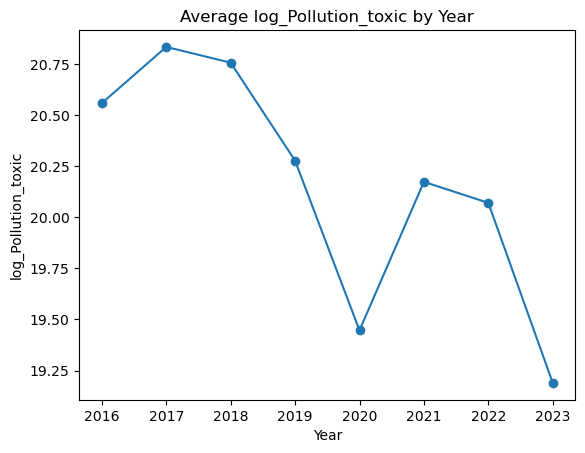

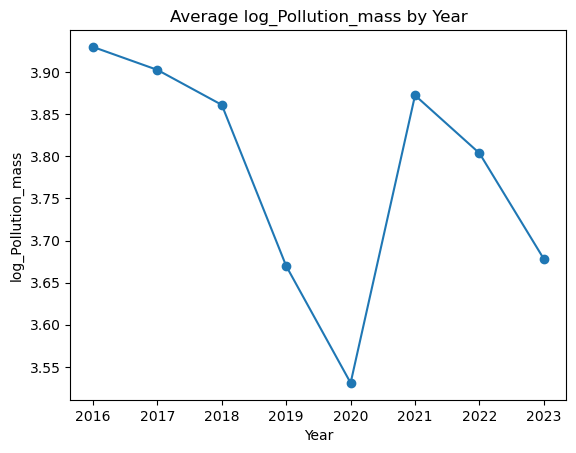

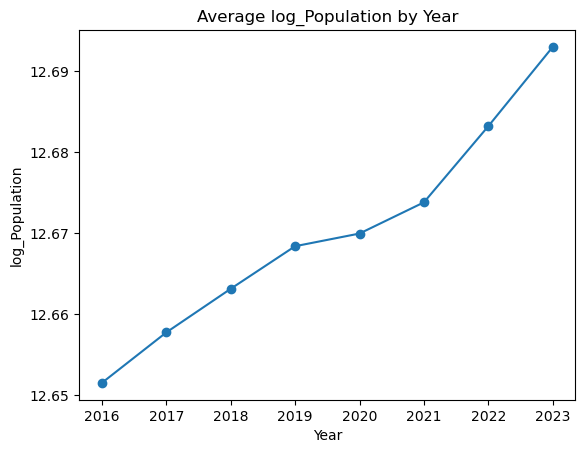

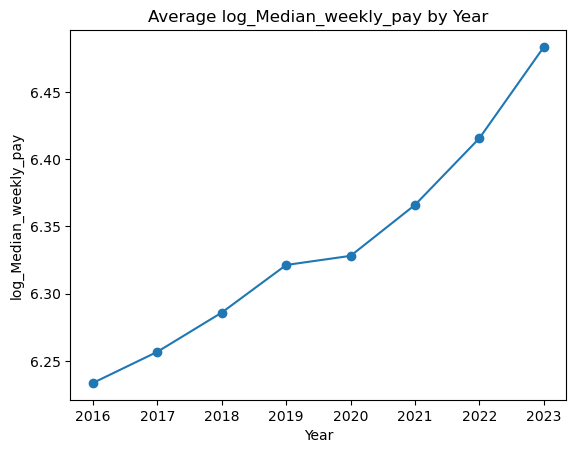

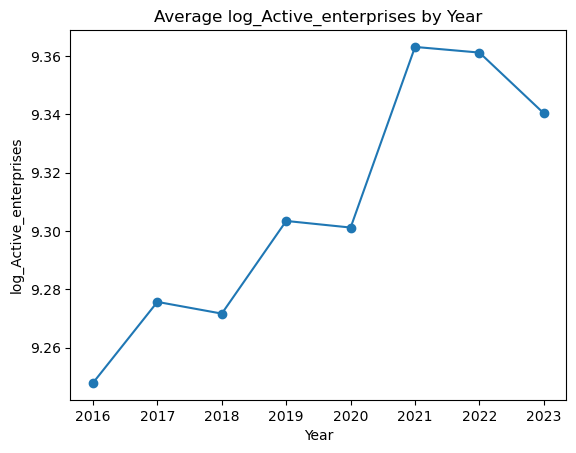

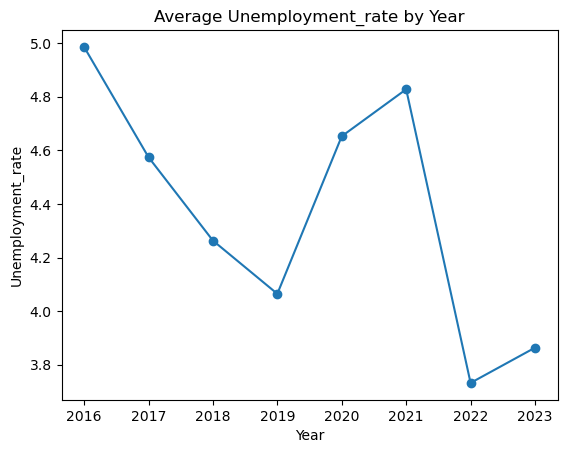

In [26]:
import matplotlib.pyplot as plt

vars_to_check = ["log_Pollution_toxic", "log_Pollution_mass",
                 "log_Population", "log_Median_weekly_pay", 
                 "log_Active_enterprises", "Unemployment_rate"]

for var in vars_to_check:
    yearly_avg = df[var].groupby("Year").mean()
    plt.figure()
    yearly_avg.plot(marker='o', title=f"Average {var} by Year")
    plt.ylabel(var)
    plt.show()


In [27]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

df = pd.read_csv("panel_regression_data.csv")

numeric_cols = ["Pollution_mass", "Pollution_toxic", "Population",
                "Active_enterprises", "Median_weekly_pay", "Unemployment_rate"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

log_vars = ["Pollution_mass", "Pollution_toxic", "Population",
            "Active_enterprises", "Median_weekly_pay"]

for var in log_vars:
    df[f"log_{var}"] = np.log1p(df[var])  # log1p handles zeros safely

print(df[[var for var in df.columns if "log_" in var]].head())
df["Year"] = df["Year"].astype(int)
df


df = df.sort_values(["UTLA", "Year"])
df = df.set_index(["UTLA", "Year"])


vars_to_diff = ["log_Pollution_toxic", 
                "log_Pollution_mass",
                "log_Median_weekly_pay", 
                "log_Active_enterprises", 
                "log_Population"]

for var in vars_to_diff:
    df[f"d_{var}"] = df.groupby(level=0)[var].diff()

df["d_Unemployment_rate"] = df.groupby(level=0)["Unemployment_rate"].diff()
y = "d_log_Pollution_toxic"
X_vars = ["d_log_Median_weekly_pay", 
          "d_log_Active_enterprises", 
          "d_log_Population", 
          "d_Unemployment_rate"]

fe_changes_model = PanelOLS(df[y], df[X_vars], time_effects=True)
res_changes = fe_changes_model.fit(cov_type="clustered", cluster_entity=True)
print(res_changes.summary)


   log_Pollution_mass  log_Pollution_toxic  log_Population  \
0            0.000000             0.000000       12.259841   
1            0.000000             0.000000       12.388653   
2            4.654912            26.183845       12.130853   
3            4.955968            26.421635       12.065108   
4            8.165395            32.287744       12.404952   

   log_Active_enterprises  log_Median_weekly_pay  
0                8.936693               6.365267  
1                8.281724               6.090178  
2                9.053804               6.284507  
3                8.895767               6.277958  
4                9.195328               6.328294  
                            PanelOLS Estimation Summary                            
Dep. Variable:     d_log_Pollution_toxic   R-squared:                        0.0014
Estimator:                      PanelOLS   R-squared (Between):             -0.0313
No. Observations:                    889   R-squared (Within):       

In [28]:

change_vars = ["d_log_Median_weekly_pay", 
               "d_log_Active_enterprises", 
               "d_log_Population", 
               "d_Unemployment_rate"]

for var in change_vars:
    df[f"{var}_lag1"] = df.groupby(level=0)[var].shift(1)

X_vars_lagged = change_vars + [f"{v}_lag1" for v in change_vars]

fe_changes_lagged = PanelOLS(df["d_log_Pollution_toxic"], df[X_vars_lagged], time_effects=True)
res_changes_lagged = fe_changes_lagged.fit(cov_type="clustered", cluster_entity=True)

print(res_changes_lagged.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     d_log_Pollution_toxic   R-squared:                        0.0043
Estimator:                      PanelOLS   R-squared (Between):              0.0714
No. Observations:                    762   R-squared (Within):               0.0038
Date:                   Tue, Aug 19 2025   R-squared (Overall):              0.0073
Time:                           00:02:17   Log-likelihood                   -2300.0
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      0.4048
Entities:                            127   P-value                           0.9181
Avg Obs:                          6.0000   Distribution:                   F(8,748)
Min Obs:                          6.0000                                           
Max Obs:                          6.0000   F-statistic (robust):            

C:\Users\andre\anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [29]:
from linearmodels.panel import PanelOLS

df["inter_ent_pop"] = df["d_log_Active_enterprises"] * df["d_log_Population"]
df["inter_ent_pay"] = df["d_log_Active_enterprises"] * df["d_log_Median_weekly_pay"]
df["inter_pop_pay"] = df["d_log_Population"] * df["d_log_Median_weekly_pay"]

X_vars_inter = [
    "d_log_Active_enterprises", 
    "d_log_Median_weekly_pay",
    "d_log_Population",
    "d_Unemployment_rate",
    "inter_ent_pay"]

fe_changes_inter = PanelOLS(
    df["d_log_Pollution_toxic"], 
    df[X_vars_inter], 
    time_effects=True
)
res_changes_inter = fe_changes_inter.fit(cov_type="clustered", cluster_entity=True)

print(res_changes_inter.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     d_log_Pollution_toxic   R-squared:                        0.0015
Estimator:                      PanelOLS   R-squared (Between):             -0.0300
No. Observations:                    889   R-squared (Within):              -0.0011
Date:                   Tue, Aug 19 2025   R-squared (Overall):             -0.0023
Time:                           00:02:17   Log-likelihood                   -2644.9
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      0.2677
Entities:                            127   P-value                           0.9308
Avg Obs:                          7.0000   Distribution:                   F(5,877)
Min Obs:                          7.0000                                           
Max Obs:                          7.0000   F-statistic (robust):            

In [50]:
from linearmodels.panel import PanelOLS

df["inter_ent_pop"] = df["log_Active_enterprises"] * df["log_Population"]
df["inter_ent_pay"] = df["log_Active_enterprises"] * df["log_Median_weekly_pay"]
df["inter_pop_pay"] = df["log_Population"] * df["log_Median_weekly_pay"]
df["log_enterp_sq"]=df["log_Active_enterprises"] * df["log_Active_enterprises"]
df["log_pay_sq"]=df["log_Median_weekly_pay"] * df["log_Median_weekly_pay"]
df["log_pop_sq"]=df["log_Population"] *df["log_Population"]
df["log_unemp_sq"]=df["Unemployment_rate"] *df["Unemployment_rate"]

X_vars_inter = [
    "log_Active_enterprises", 
    "log_Median_weekly_pay",
    "log_Population",
    "Unemployment_rate"
]

import numpy as np

n_utlas = 127
n_years = 8
years = list(range(2016, 2016 + n_years))

df["UTLA"] = np.repeat(range(n_utlas), n_years)
df["Year"] = years * n_utlas

df = df.set_index(["UTLA", "Year"])

fe_changes_inter = PanelOLS(
    df["log_Pollution_toxic"], 
    df[X_vars_inter], 
    entity_effects=True, 
    time_effects=True     
)

res_changes_inter = fe_changes_inter.fit(cov_type="clustered", cluster_entity=True)

print(res_changes_inter.summary)


                           PanelOLS Estimation Summary                           
Dep. Variable:     log_Pollution_toxic   R-squared:                        0.0061
Estimator:                    PanelOLS   R-squared (Between):             -20.847
No. Observations:                 1016   R-squared (Within):               0.0124
Date:                 Wed, Aug 27 2025   R-squared (Overall):             -20.272
Time:                         16:40:59   Log-likelihood                   -2832.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.3551
Entities:                          127   P-value                           0.2478
Avg Obs:                        8.0000   Distribution:                   F(4,878)
Min Obs:                        8.0000                                           
Max Obs:                        8.0000   F-statistic (robust):             0.9294
                

Pollution_mass  Pollution_toxic  Population  Unemployment_rate  \
UTLA Year                                                                   
0    2016            0.00     0.000000e+00      211047           6.857532   
     2017            0.00     0.000000e+00      214017           7.674968   
     2018            0.00     0.000000e+00      216298           5.888995   
     2019            0.00     0.000000e+00      218828           5.728820   
     2020            0.00     0.000000e+00      219227           7.892003   
...                   ...              ...         ...                ...   
126  2019           51.00     5.100000e+10      203877           2.824120   
     2020           51.50     5.150000e+10      202169           2.975741   
     2021           50.60     5.060000e+10      201851           3.233788   
     2022           50.63     5.063000e+10      204115           1.789327   
     2023           43.77     4.377000e+10      206780           2.522022   

           Active_enterprises  Median_weekly_pay  log_Pollution_mass  \
UTLA Year                                                              
0    2016                7605              580.3            0.000000   
     2017                7930              605.5            0.000000   
     2018                8030              579.1            0.000000   
     2019                8440              569.5            0.000000   
     2020                8855              621.8            0.000000   
...                       ...                ...                 ...   
126  2019                7565              579.6            3.951244   
     2020                7425              578.8            3.960813   
     2021                7515              637.9            3.943522   
     2022                7535              622.2            3.944103   
     2023                7430              671.7            3.801538   

           log_Pollution_toxic  log_Population  log_Active_enterprises  ...  \
UTLA Year                                                               ...   
0    2016             0.000000       12.259841                8.936693  ...   
     2017             0.000000       12.273815                8.978534  ...   
     2018             0.000000       12.284417                8.991064  ...   
     2019             0.000000       12.296046                9.040856  ...   
     2020             0.000000       12.297868                9.088850  ...   
...                        ...             ...                     ...  ...   
126  2019            24.655091       12.225277                8.931420  ...   
     2020            24.664848       12.216864                8.912743  ...   
     2021            24.647217       12.215290                8.924789  ...   
     2022            24.647810       12.226444                8.927447  ...   
     2023            24.502214       12.239416                8.913416  ...   

           d_log_Active_enterprises_lag1  d_log_Population_lag1  \
UTLA Year                                                         
0    2016                            NaN                    NaN   
     2017                            NaN                    NaN   
     2018                       0.041842               0.013975   
     2019                       0.012530               0.010602   
     2020                       0.049792               0.011629   
...                                  ...                    ...   
126  2019                       0.006078               0.001767   
     2020                       0.018677              -0.000142   
     2021                      -0.018677              -0.008413   
     2022                       0.012047              -0.001574   
     2023                       0.002657               0.011154   

           d_Unemployment_rate_lag1  inter_ent_pop  inter_ent_pay  \
UTLA Year                                                           
0    2016                       Na

In [45]:
import numpy as np

n_utlas = 127
n_years = 8
years = list(range(2016, 2016 + n_years))

df["UTLA"] = np.repeat(range(n_utlas), n_years)
df["Year"] = years * n_utlas

df = df.set_index(["UTLA", "Year"])

from linearmodels.panel import PanelOLS

X_vars_inter = [
    "log_Active_enterprises", 
    "log_Median_weekly_pay",
    "log_Population",
    "Unemployment_rate",
]

fe_changes_inter = PanelOLS(
    df["log_Pollution_toxic"],
    df[X_vars_inter],
    entity_effects=True,
    time_effects=True
)

res_changes_inter = fe_changes_inter.fit(cov_type="clustered", cluster_entity=True)
print(res_changes_inter.summary)


                           PanelOLS Estimation Summary                           
Dep. Variable:     log_Pollution_toxic   R-squared:                        0.0061
Estimator:                    PanelOLS   R-squared (Between):             -20.847
No. Observations:                 1016   R-squared (Within):               0.0124
Date:                 Wed, Aug 27 2025   R-squared (Overall):             -20.272
Time:                         16:11:00   Log-likelihood                   -2832.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.3551
Entities:                          127   P-value                           0.2478
Avg Obs:                        8.0000   Distribution:                   F(4,878)
Min Obs:                        8.0000                                           
Max Obs:                        8.0000   F-statistic (robust):             0.9294
                

In [ ]:
#df.to_csv('regdf.csv', index=False)